In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
import copy
%matplotlib inline
import skimage.segmentation
from sklearn.linear_model import LinearRegression
from skimage.color import gray2rgb
import os
from PIL import Image


In [2]:
import matlab.engine
eng = matlab.engine.connect_matlab()
eng.cd(r'/Users/nunemunthalashiva/Documents/BTP/xai_thyroid/Code', nargout=0)
eng.plus(2,3)

5

2.0


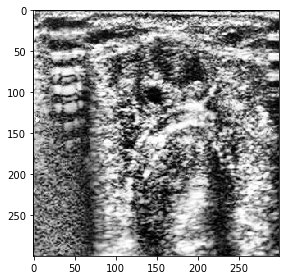

In [61]:
img = skimage.io.imread('xai_thyroid/Data_temp/datapre/3_1.jpg')
img=gray2rgb(img)
skimage.io.imshow(img)
pred = eng.test_with_single_input(7200,"hot")
print(pred)

# Custom Local Interpretable Model-Agnostic Explainations

<b><h2>Generating random perbutations of image using quick-shift segmentation algorithm to compute the super-pixels in the image</h2></b>

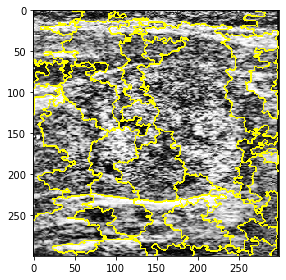

In [4]:
# img = pre-processed image , dist = a number nearer to length of image , img :  preprocessed one
# ratio : Balances color-space proximity and image-space proximity. Higher values give more weight to color-space
# kernel_size = Width of Gaussian kernel used in smoothing the sample density. Higher means fewer clusters
# max_dist = Cut-off point for data distances. Higher means fewer clusters.
superpixels = skimage.segmentation.slic(img, n_segments=250, compactness=4.5, sigma=1,
                     start_label=1)
#superpixels = skimage.segmentation.quickshift(img,ratio=0.4,kernel_size=6,max_dist=150)
#superpixels = skimage.segmentation.felzenszwalb(img, scale=1, sigma=0.9, min_size=250)
num_superpixels = np.unique(superpixels).shape[0]
skimage.io.imshow(skimage.segmentation.mark_boundaries(img, superpixels))

In [5]:

img.shape

(300, 300, 3)

In [25]:
#Generate perturbations
num_perturb = 250
#drawing samples from binomial distribuition with prob=0.5 and n=1
perturbations = np.random.binomial(1, 0.75, size=(num_perturb, num_superpixels))

#Create function to apply perturbations to Zimages
#segments are superpixels we pass it into perturb_image function
def perturb_image(img,perturbation,segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image



In [26]:
tmp_img=perturb_image(img,perturbations[15],superpixels).astype('uint8')

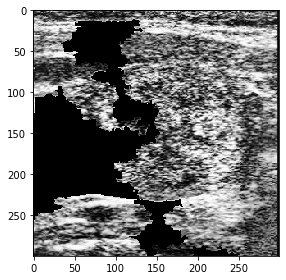

In [27]:
skimage.io.imshow(tmp_img)

In [28]:
tmp_img_lst = matlab.double(tmp_img.tolist())
res=eng.features_of_single_image(tmp_img_lst,nargout=2)
[label,score] = eng.return_probs_hog(res[0],nargout=2)

In [29]:
print(label)
print(score)

2.0
[[0.19607986117399345,0.8039201388260065]]


In [30]:
print(score[0][0]+score[0][1])

1.0


<h3><b>predicting output of each perturbation </b></h3>

In [31]:
predictions = []
for pert in perturbations:
    perturbed_img = perturb_image(img,pert,superpixels)
    
    try:
        im = Image.fromarray((perturbed_img * 255).astype(np.uint8))
    except Exception as e:
        print(e)
    #pred=eng.test_with_single_input_7200_hot(im)
    im.save('/Users/nunemunthalashiva/Documents/BTP/xai_thyroid/temp/temp_img.jpg', 'JPEG')
    pred = eng.test_with_single_input(7200,"hot") #get output from matlab regarding image of benign vs malignant
    pred=int(pred)
    predictions.append(pred)

predictions = np.array(predictions)
print(predictions)

[2 1 2 2 1 2 2 1 1 1 2 2 1 2 1 2 2 2 2 2 1 1 2 1 2 2 2 2 1 2 2 1 1 2 1 1 1
 1 1 2 1 2 1 1 1 2 1 2 1 1 1 2 2 2 1 2 1 2 1 1 2 2 1 1 1 1 1 1 1 1 2 1 2 1
 2 1 1 1 1 2 1 2 2 1 1 2 1 2 1 1 1 1 1 1 2 2 2 2 2 1 1 1 1 1 2 1 1 2 2 2 2
 1 2 2 1 1 1 2 2 1 2 1 1 2 1 1 1 1 2 2 2 1 2 1 2 1 2 1 2 2 2 2 1 2 1 2 1 1
 1 1 2 2 2 1 1 1 1 2 2 1 2 1 1 1 1 1 2 2 1 1 1 2 1 1 2 1 2 1 1 1 2 2 2 1 2
 1 1 2 1 1 2 2 2 1 2 1 2 1 1 1 1 1 2 2 2 1 1 1 2 1 1 1 1 1 1 2 1 2 1 1 1 1
 2 1 2 2 1 1 1 1 1 1 2 1 1 2 1 2 2 1 2 1 1 1 1 1 2 2 1 1]


In [32]:
print(predictions.shape)

(250,)


<h3><b>Finding how close each perturbation is to original image </b></h3>

In [33]:
#Compute distances to original image
import sklearn.metrics
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
print(distances.shape)

#Transform distances to a value between 0 an 1 (weights) using a kernel function
kernel_width = 0.25
#gaussian kernel function
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) 
print(weights.shape)
print(weights)

(250,)
(250,)
[0.92968449 0.86623977 0.5787682  0.81349892 0.84085506 0.91072435
 0.84085506 0.84085506 0.86623977 0.86623977 0.94639291 0.72084977
 0.86623977 0.94639291 0.72084977 0.92968449 0.84085506 0.96082319
 0.94639291 0.96082319 0.92968449 0.78428699 0.86623977 0.81349892
 0.78428699 0.86623977 0.86623977 0.88955582 0.86623977 0.92968449
 0.88955582 0.88955582 0.84085506 0.94639291 0.72084977 0.97296502
 0.91072435 0.88955582 0.92968449 0.86623977 0.94639291 0.97296502
 0.78428699 0.84085506 0.61569673 0.75335326 0.78428699 0.91072435
 0.84085506 0.86623977 0.65182778 0.68694594 0.84085506 0.81349892
 0.68694594 0.84085506 0.84085506 0.75335326 0.81349892 0.91072435
 0.88955582 0.81349892 0.84085506 0.88955582 0.81349892 0.84085506
 0.94639291 0.88955582 0.78428699 0.94639291 0.84085506 0.86623977
 0.96082319 0.78428699 0.88955582 0.91072435 0.86623977 0.84085506
 0.86623977 0.96082319 0.88955582 0.86623977 0.68694594 0.81349892
 0.91072435 0.78428699 0.91072435 0.92968449 0.8

<h3><b> Fitting linear model using perturbations,predictions,weights</b></h3>

[31 29  9 42 14 28 13 38 40 39  0 10 21 16 30 34 36 26 37  8]


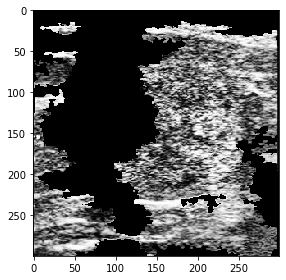

In [36]:
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions, sample_weight=weights)
coeff = simpler_model.coef_
#print(coeff.shape)

#Use coefficients from linear model to extract top features
num_top_features = 20
top_features = np.argsort(coeff)[-num_top_features:] 
print(top_features)
#Show only the superpixels corresponding to the top features
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
#skimage.io.imshow((perturb_image(img,mask,superpixels)*255).astype(np.uint8),vmin=0,vmax=255)
#skimage.io.imshow(perturb_image(img,mask,superpixels).astype('uint8'))
#top_30_features=perturb_image(img,mask,superpixels).astype('uint8')
skimage.io.imshow(perturb_image(img,mask,superpixels).astype('uint8'))

# testing code in python && LIME library

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
import copy
%matplotlib inline
import skimage.segmentation
from sklearn.linear_model import LinearRegression
from skimage.color import gray2rgb
import os
from PIL import Image
from lime import lime_image

In [2]:
import matlab.engine
eng = matlab.engine.connect_matlab()
eng.cd(r'/Users/nunemunthalashiva/Documents/BTP/xai_thyroid/Code', nargout=0)
eng.plus(2,3)


In [55]:
import matplotlib
def test_with_single_input_7200_hot(images):
    #image=skimage.io.imread(image,format='jpeg')
    num_imgs=images.shape[0]
    result=np.zeros((num_imgs,2))
    for i in range(num_imgs):
        image=images[i]
        image = matlab.double(image.tolist())
        res=eng.features_of_single_image(image,nargout=2)
        [label,score] = eng.return_probs_hog(res[0],nargout=2)
        temp=np.asarray(score)
        result[i][0]=temp[0][0]
        result[i][1]=temp[0][1]
    return result

In [56]:
explainer = lime_image.LimeImageExplainer()
image=matplotlib.image.imread('xai_thyroid/Data_temp/datapre/3_1.jpg')
image=gray2rgb(image)
image=np.reshape(image,(1,300,300,3))
score=test_with_single_input_7200_hot(image) 
#test_with_single_input_7200_hot(image)

In [57]:
print(score)

[[0.00138337 0.99861663]]


In [58]:
import time
tic=time.time()
import warnings
warnings.filterwarnings("ignore")
tmp_img=matplotlib.image.imread('xai_thyroid/Data_temp/datapre/3_1.jpg')
explanation = explainer.explain_instance(tmp_img, test_with_single_input_7200_hot, num_samples=350)
toc=time.time()
print("It took {} secs to explain this image".format(toc-tic))

  0%|          | 0/350 [00:00<?, ?it/s]

It took 1473.2423422336578 secs to explain this image


(-0.5, 299.5, 299.5, -0.5)

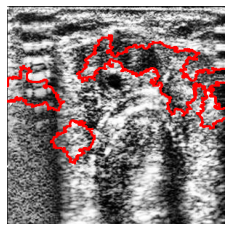

In [68]:
from skimage.segmentation import mark_boundaries
from skimage.segmentation import clear_border,flood_fill
#temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=20, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=12
                                                , hide_rest=False)

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
#ax1.imshow(mark_boundaries(temp_1, mask_1))
plt.imshow(mark_boundaries(temp_2, mask_2,color=(1, 0, 0),mode='inner',outline_color=(1,0,0)))
#ax1.axis('off')
plt.axis('off')




# shap

In [1]:
import shap
import cv2
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
import copy
%matplotlib inline
import skimage.segmentation
from sklearn.linear_model import LinearRegression
from skimage.color import gray2rgb
import os
from PIL import Image

In [2]:
import matlab.engine
eng = matlab.engine.connect_matlab()
eng.cd(r'/Users/nunemunthalashiva/Documents/BTP/xai_thyroid/Code', nargout=0)
eng.plus(2,3)

5

In [6]:
import shap
X=matplotlib.image.imread('xai_thyroid/Data_temp/datapre/3_1.jpg')
X=gray2rgb(X)
X=np.reshape(X,(1,300,300,3))
X=X.astype(np.float64)
print(X.shape)
print(X.dtype)

(1, 300, 300, 3)
float64


In [7]:
import matplotlib
def test_with_single_input_7200_hot_shap(images):
    #image=skimage.io.imread(image,format='jpeg')
    num_imgs=images.shape[0]
    result=np.zeros((num_imgs,2))
    for i in range(num_imgs):
        image=images[i]
        image = matlab.double(image.tolist())
        res=eng.features_of_single_image(image,nargout=2)
        [label,score] = eng.return_probs_hog(res[0],nargout=2)
        #print(label)
        temp=np.asarray(score)
        result[i][0]=temp[0][0]
        result[i][1]=temp[0][1]
    return result

In [8]:
print(X.shape)
ans=test_with_single_input_7200_hot_shap(X)
print(ans.shape)
print(ans)

(1, 300, 300, 3)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
(1, 2)
[[0. 1.]]


In [9]:
print(ans.dtype)
ans[0][1]

float64


1.0

In [10]:
res=test_with_single_input_7200_hot_shap(X)

> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)


In [11]:
res.shape

(1, 2)

In [12]:
X[0].shape

(300, 300, 3)

In [13]:
masker = shap.maskers.Image("inpaint_telea", X[0].shape)


In [14]:
explainer = shap.Explainer(test_with_single_input_7200_hot_shap, masker, output_names=['benign','malignant'])

In [15]:
shap_values = explainer(X, max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:3])

> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)


  0%|          | 0/248 [00:00<?, ?it/s]

> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (li

> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (li

> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (li

> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (li

> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (li

Partition explainer: 2it [36:44, 2204.35s/it]                                   


In [16]:
shap_values.shape

(1, 300, 300, 3, 2)

In [17]:
shap_values

.values =
array([[[[[ 4.73283963e-19, -4.73283963e-19],
          [ 4.73283963e-19, -4.73283963e-19],
          [ 4.73283963e-19, -4.73283963e-19]],

         [[ 4.73283963e-19, -4.73283963e-19],
          [ 4.73283963e-19, -4.73283963e-19],
          [ 4.73283963e-19, -4.73283963e-19]],

         [[ 4.73283963e-19, -4.73283963e-19],
          [ 4.73283963e-19, -4.73283963e-19],
          [ 4.73283963e-19, -4.73283963e-19]],

         ...,

         [[ 0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00]],

         [[ 0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00]],

         [[ 0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00]]],


        [[[ 4.73283963e-19, -4.73283963e-19],
          [ 4.73283963e-19, -4.73283963e-19],
          [ 4.73283963e-19, -4.73283963e-

In [18]:
shap_values.output_names

['malignant', 'benign']

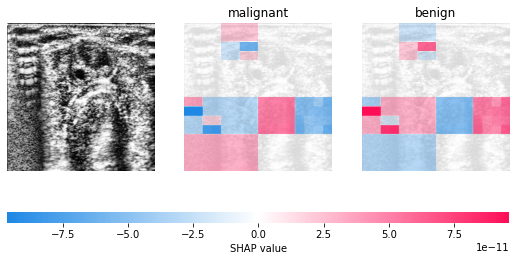

In [19]:
shap.image_plot(shap_values)

In [33]:
np.tile(np.array(shap_values.output_names), 2)

array([1, 1])

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
import copy
%matplotlib inline
import skimage.segmentation
from sklearn.linear_model import LinearRegression
from skimage.color import gray2rgb
import os
from PIL import Image
import matlab.engine
eng = matlab.engine.connect_matlab()
eng.cd(r'/Users/nunemunthalashiva/Documents/BTP/xai_thyroid/Code', nargout=0)
eng.plus(2,3)

In [26]:
out = test_with_single_input_7200_hot_shap(X)
classes = np.argmax(out, axis=1)
print(classes)

[0]


In [27]:
masker_blur = shap.maskers.Image("blur(16,32)", X[0].shape)
class_names=['benign','malignant']
explainer_blur = shap.Explainer(test_with_single_input_7200_hot_shap, masker_blur, output_names=class_names)

# here we explain two images using 300 evaluations of the underlying model to estimate the SHAP values
shap_values_fine = explainer_blur(X, max_evals=500, batch_size=100, outputs=shap.Explanation.argsort.flip[:2])


  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 2it [19:44, 1184.78s/it]                                   


In [28]:
shap_values_fine.shape

(1, 300, 300, 3, 2)

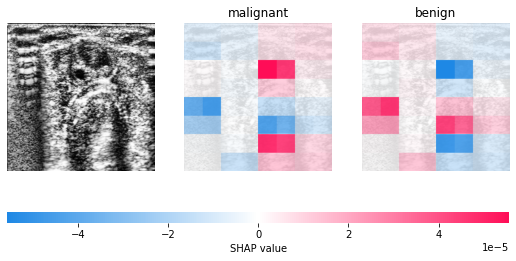

In [29]:
shap.image_plot(shap_values_fine)

In [30]:
print(shap_values_fine.data.shape, shap_values_fine.values.shape)

(1, 300, 300, 3) (1, 300, 300, 3, 2)


In [31]:
shap_values_fine.output_names

['malignant', 'benign']

In [32]:
shap_values_fine.data = shap_values_fine.data[0]
shap_values_fine.values = [val for val in np.moveaxis(shap_values_fine.values[0],-1, 0)]

In [33]:
shap_values_fine.data.shape

(300, 300, 3)

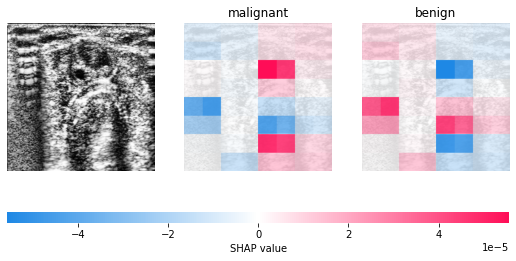

In [34]:
shap.image_plot(shap_values=shap_values_fine.values,
                pixel_values=shap_values_fine.data,
                labels=shap_values_fine.output_names)

In [61]:
shap_values_fine.shape
shap_values_fine.__dict__

{'op_history': [],
 'compute_time': 170.96832013130188,
 'output_dims': (4,),
 '_s': Slicer({'o': [], 'values': [array([[[-2.07883753e-06, -2.07883753e-06, -2.07883753e-06],
         [-2.07883753e-06, -2.07883753e-06, -2.07883753e-06],
         [-2.07883753e-06, -2.07883753e-06, -2.07883753e-06],
         ...,
         [ 2.00456853e-06,  2.00456853e-06,  2.00456853e-06],
         [ 2.00456853e-06,  2.00456853e-06,  2.00456853e-06],
         [ 2.00456853e-06,  2.00456853e-06,  2.00456853e-06]],
 
        [[-2.07883753e-06, -2.07883753e-06, -2.07883753e-06],
         [-2.07883753e-06, -2.07883753e-06, -2.07883753e-06],
         [-2.07883753e-06, -2.07883753e-06, -2.07883753e-06],
         ...,
         [ 2.00456853e-06,  2.00456853e-06,  2.00456853e-06],
         [ 2.00456853e-06,  2.00456853e-06,  2.00456853e-06],
         [ 2.00456853e-06,  2.00456853e-06,  2.00456853e-06]],
 
        [[-2.07883753e-06, -2.07883753e-06, -2.07883753e-06],
         [-2.07883753e-06, -2.07883753e-06, -2.0

In [59]:
shap_values_fine[0].shape

(300, 300, 3)

In [62]:
shap_values = shap_values_fine(X[:1])
shap_values

TypeError: 'Explanation' object is not callable

In [35]:
shap.plots.heatmap(shap_values_fine, feature_values=shap_values_fine.abs.max(0))

AttributeError: 'list' object has no attribute 'shape'

# Computing saliency masks with the PAIRML saliency library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
import copy
import skimage.segmentation
from sklearn.linear_model import LinearRegression
from skimage.color import gray2rgb
import os
from PIL import Image
import matlab.engine
eng = matlab.engine.connect_matlab()
eng.cd(r'/Users/nunemunthalashiva/Documents/BTP/xai_thyroid/Code', nargout=0)
eng.plus(2,3)
import PIL.Image
from matplotlib import pylab as P
import saliency.core as saliency
%matplotlib inline


# utility methods

In [17]:
def ShowImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im)
    P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')

    P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
    P.title(title)

def ShowHeatMap(im, title="", ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap='inferno')
    P.title(title)

def LoadImage(file_path):
    im = PIL.Image.open(file_path)
    im = np.asarray(im)
    return im




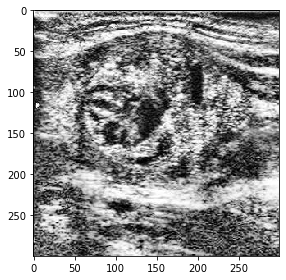

In [18]:
img = skimage.io.imread('xai_thyroid/Data_temp/datapre/4_1.jpg')
#img=gray2rgb(img)
skimage.io.imshow(img)

In [20]:
im=LoadImage('xai_thyroid/Data_temp/datapre/4_1.jpg')

In [21]:
im

array([[255, 247, 100, ...,   1,   7,   0],
       [255, 251, 230, ..., 154, 167, 158],
       [244, 255, 245, ..., 119, 120, 120],
       ...,
       [ 27, 111, 113, ..., 156, 188, 207],
       [ 15, 101, 122, ..., 103, 142, 146],
       [  0,  95, 160, ...,  42,  67,  67]], dtype=uint8)

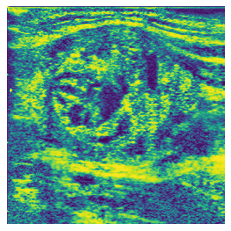

In [22]:
ShowImage(im)

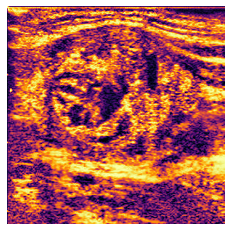

In [23]:
ShowHeatMap(im)

# Visualising HOG

In [1]:
import matplotlib.pyplot as plt
from skimage import io
from skimage import color
from skimage.transform import resize
import math
from skimage.feature import hog
import numpy as np

In [2]:
path = 'xai_thyroid/Data_temp/datapre/2_1.jpg'
img = io.imread(path)

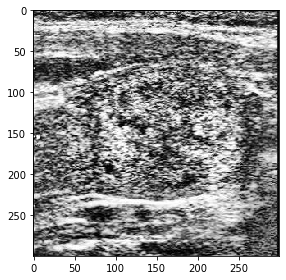

In [3]:
io.imshow(img)

In [4]:
img = np.array(img,dtype='int64')

In [5]:
img.shape
print(img.dtype)

int64


/var/folders/pn/qj1x6mg13gsf4xt15gc9gff00000gn/T/ipykernel_11089/1124597713.py:1: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),


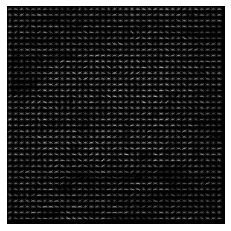

In [6]:
fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True, multichannel=False)
plt.axis("off")
plt.imshow(hog_image, cmap="gray")
plt.show()



In [7]:
mag = []
theta = []
for i in range(300):
    magnitudeArray = []
    angleArray = []
    for j in range(300):

    # Condition for axis 0

        if j - 1 <= 0 or j + 1 >= 300:
            if j - 1 <= 0:

        # Condition if first element

                Gx = img[i][j + 1] - 0
            elif j + 1 >= len(img[0]):
                Gx = 0 - img[i][j - 1]
        else:

    # Condition for first element

            Gx = img[i][j + 1] - img[i][j - 1]

    # Condition for axis 1

        if i - 1 <= 0 or i + 1 >= 300:
            if i - 1 <= 0:
                Gy = 0 - img[i + 1][j]
            elif i + 1 >= 300:
                Gy = img[i - 1][j] - 0
        else:
            Gy = img[i - 1][j] - img[i + 1][j]

    # Calculating magnitude

        magnitude = math.sqrt(pow(Gx, 2) + pow(Gy, 2))
        magnitudeArray.append(round(magnitude, 9))

    # Calculating angle

        if Gx == 0:
            angle = math.degrees(0.0)
        else:
            angle = math.degrees(abs(math.atan(Gy / Gx)))
        angleArray.append(round(angle, 9))
    mag.append(magnitudeArray)
    theta.append(angleArray)


In [8]:
theta = np.array(theta)
mag = np.array(mag)

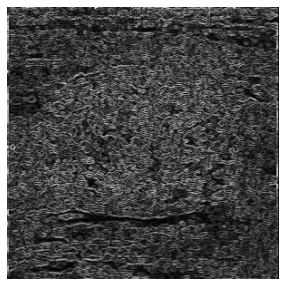

In [9]:
# visualizing magnitude   
plt.figure(figsize=(5, 5))
plt.imshow(mag,cmap="gray")
plt.axis("off")
plt.show()


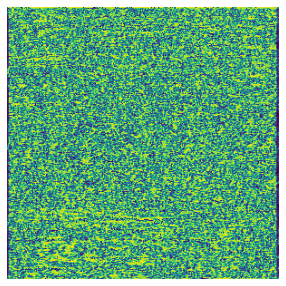

In [12]:
plt.figure(figsize=(5, 5))
plt.imshow(theta)
plt.axis("off")
plt.show()

# Reading xml file and plotting coordinates on image

In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
import copy
%matplotlib inline
import skimage.segmentation
from sklearn.linear_model import LinearRegression
from skimage.color import gray2rgb
import os
from PIL import Image
import json

In [2]:
def print_annotated_image_by_doctor(xml_url,image_path):
    lst=list()
    tree = ET.parse(xml_url)
    root = tree.getroot()
    for child in root:
        if child.tag=='mark':
            for child_child in child:
                if child_child.tag=='svg':
                    lst=json.loads(child_child.text)
    points=lst[0]["points"]
    n=len(lst[0]["points"])
    coordinates=np.zeros((n,2))
    for i in range(n):
        coordinates[i][0]=points[i]['x']
        coordinates[i][1]=points[i]['y']
    image = skimage.io.imread(image_path)
    plt.imshow(image)
    plt.plot("og", markersize=10)  # og:shorthand for green circle
    plt.scatter(coordinates[:, 0], coordinates[:, 1], marker="o", color="yellow", s=20)
    plt.show()
    print(image.shape)

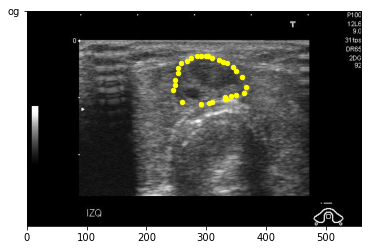

(360, 560, 3)


In [3]:
xml_url = "ddti/3.xml"
image_path='ddti/3_1.jpg'
print_annotated_image_by_doctor(xml_url,image_path)

# SHAP clean code

In [4]:
import shap
import cv2
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
import copy
%matplotlib inline
import skimage.segmentation
from sklearn.linear_model import LinearRegression
from skimage.color import gray2rgb
import os
from PIL import Image

import matlab.engine
eng = matlab.engine.connect_matlab()
eng.cd(r'/Users/nunemunthalashiva/Documents/BTP/xai_thyroid/Code', nargout=0)

def test_with_single_input_7200_hot_shap(images):
    #image=skimage.io.imread(image,format='jpeg')
    num_imgs=images.shape[0]
    result=np.zeros((num_imgs,2))
    for i in range(num_imgs):
        image=images[i]
        image = matlab.double(image.tolist())
        res=eng.features_of_single_image(image,nargout=2)
        [label,score] = eng.return_probs_hog(res[0],nargout=2)
        #print(label)
        temp=np.asarray(score)
        result[i][0]=temp[0][0]
        result[i][1]=temp[0][1]
    return result


#'xai_thyroid/Data_temp/datapre/2_1.jpg'

In [5]:
def print_shap_output(image_path):
    X=matplotlib.image.imread(image_path)
    X=gray2rgb(X)
    X=np.reshape(X,(1,300,300,3))
    X=X.astype(np.float64)
    masker = shap.maskers.Image("inpaint_telea", X[0].shape)
    explainer = shap.Explainer(test_with_single_input_7200_hot_shap, masker, output_names=['benign','malignant'])
    shap_values = explainer(X, max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:2])
    shap.image_plot(shap_values)
    

> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)


  0%|          | 0/248 [00:00<?, ?it/s]

> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (li

> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (li

> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In glmfit (line 340)
In fitSVMPosterior (line 187)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> I

> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (line 180)
In return_probs_hog (line 5)
> In fitSVMPosterior (li

Partition explainer: 2it [42:10, 2530.24s/it]                                   


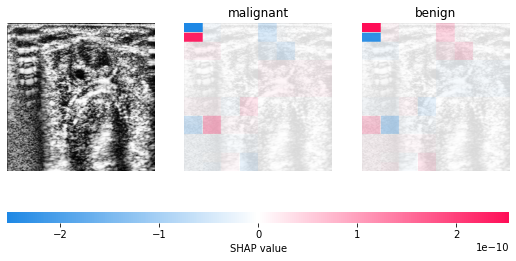

In [6]:
print_shap_output('xai_thyroid/Data_temp/datapre/3_1.jpg')